In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import sklearn.metrics
import scipy.stats
import networkx as nx
import pickle
import copy
import fortuna
sns.set()
sns.set_style("white")
import networkx as nx
from perses.analysis import load_simulations,cycles

import itertools
import os

#######################
# THINGS FOR STYLE
#######################
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

rainbow_cmap = plt.cm.get_cmap('gist_rainbow')    
green_cmap = plt.cm.get_cmap('Greens')
    
base_directory = os.getcwd()


from system_objects import *
from dataset import *

In [6]:
completed = []

forcefields = ['openff-1.0.0']#,'smirnoff99Frosst-1.1.0','gaff-2.11']#,'gaff-1.81'] # need to add these in as they're _finished_
targets = [Bace, Cdk2, Jnk1, Mcl1, Thrombin, P38a, Ptp1b, Tyk2]

forcefield_color = {}
for i, ff in zip(np.linspace(0.,1.,6), ['FEP','TI']+forcefields):
    forcefield_color[ff] = rainbow_cmap(i)

cmaps = [plt.cm.get_cmap(x) for x in ['Greens','Purples','Oranges','Reds','Blues','Blues','Blues','Blues']]
    
for cmap,target in zip(cmaps,targets):
    target.cmap = cmap

filename = 'FEP_vs_GTI-dG-SI.xlsx'
df = read_dataset(filename,targets)
for target, rows in df.groupby("Target"):
    target = globals()[target.capitalize()]
    target.exp_mean = np.mean(rows['EXP'])

 Bace 
 openff-1.0.0 
There are 1 simulations left to run for openff-1.0.0: [(27, 29)]


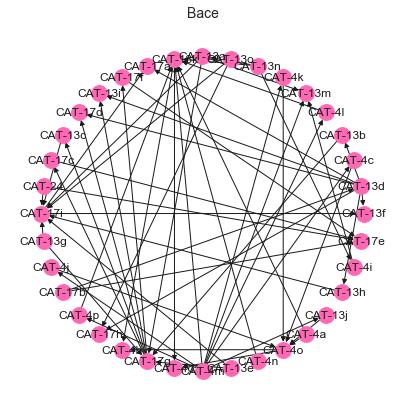

 Cdk2 
 openff-1.0.0 
There are 6 simulations left to run for openff-1.0.0: [(14, 8), (1, 9), (1, 11), (0, 11), (11, 4), (2, 11)]


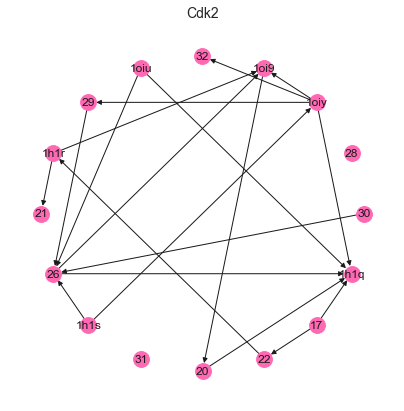

 Jnk1 
 openff-1.0.0 
There are 2 simulations left to run for openff-1.0.0: [(18, 4), (20, 15)]


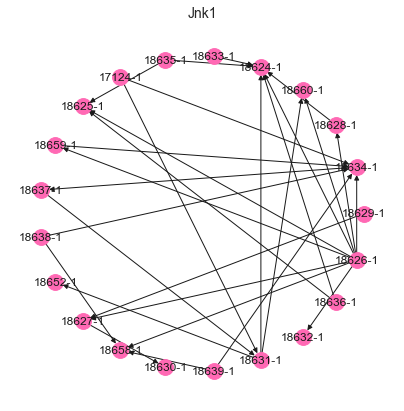

 Mcl1 
 openff-1.0.0 
There are 4 simulations left to run for openff-1.0.0: [(22, 37), (16, 21), (7, 37), (10, 37)]


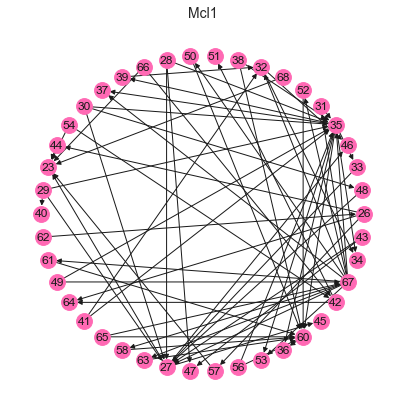

 Thrombin 
 openff-1.0.0 


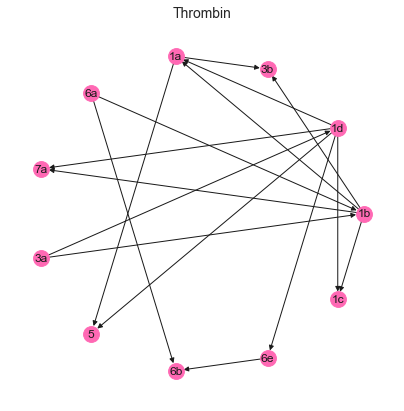

 p38a 
 openff-1.0.0 
There are 10 simulations left to run for openff-1.0.0: [(28, 22), (23, 8), (23, 2), (23, 30), (22, 32), (15, 22), (33, 22), (33, 18), (3, 15), (9, 29)]


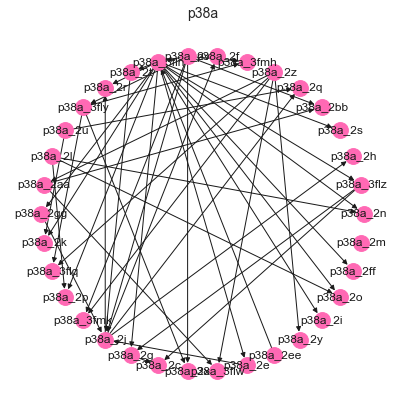

 Ptp1b 
 openff-1.0.0 
There are 3 simulations left to run for openff-1.0.0: [(17, 11), (17, 0), (17, 4)]


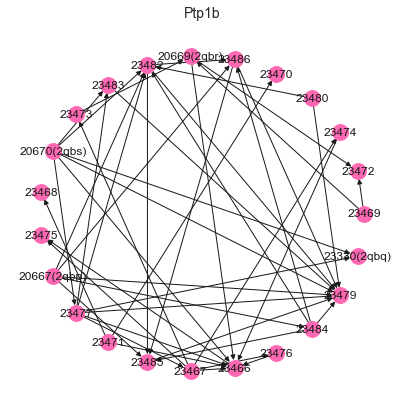

 Tyk2 
 openff-1.0.0 


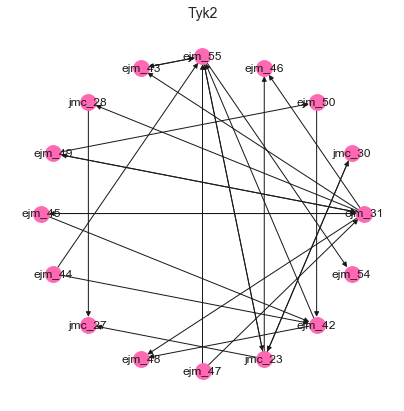

Targets completed: ['Bace', 'Cdk2', 'Jnk1', 'Mcl1', 'Thrombin', 'p38a', 'Ptp1b', 'Tyk2', 'Bace', 'Cdk2', 'Jnk1', 'Mcl1', 'Thrombin', 'p38a', 'Ptp1b', 'Tyk2', 'Bace', 'Cdk2', 'Jnk1', 'Mcl1', 'Thrombin', 'p38a', 'Ptp1b', 'Tyk2']


In [42]:
def generate_graph_results(G,target,ff,interval=None):
    finished = True
    print(f'{color.BOLD}{color.RED} {target.name} {color.END}{color.END}')

    for item in target.index_to_name:
        G.add_node(item,name=target.index_to_name[item])
    
    os.chdir(f'{base_directory}/{ff}/{target.name.lower()}/')
    print(f'{color.BOLD}{color.RED} {ff} {color.END}{color.END}')

    all_sims = []
    all_files = os.listdir()

    for file in [x for x in all_files if x[-3:] == '.pi']:
        x = pickle.load(open(file,'rb'))
        all_sims.append(x)
    
    try:
        missing = check_missing_results(target,all_sims)
    except ValueError:
        missing = []
    if len(missing) > 0 :
        finished = False
        print(f'There are {len(missing)} simulations left to run for {ff}: {missing}')

    for sim in all_sims:
        a = int(sim.ligA)
        b = int(sim.ligB)
        if not G.has_edge(a,b): # if the edge doesn't exist yet, add it
            G.add_edge(a,b)
        if interval is None: # just analyse normally
            G.edges[a,b]['f_ij_'+str(ff)] = sim.bindingdg
            G.edges[a,b]['df_ij_'+str(ff)] = sim.bindingddg
        else: 
            G.edges[a,b]['f_ij_'+str(ff)] = (sim.soldg_history[interval] - sim.comdg_history[interval])/1.69
            G.edges[a,b]['df_ij_'+str(ff)] = (sim.solddg_history[interval] - sim.comddg_history[interval])/1.69   
            
        if interval is None: # don't return the 
            setattr(target,'all_sims'+ff,all_sims)
    os.chdir(f'/Users/brucemah/bin/relative-paper/perses050')

    return G
    

for target in targets:
    # get details
    G = nx.DiGraph()
    for ff in forcefields:
        G = generate_graph_results(G,target,ff)
        target.graph = G
    completed.append(target)
    plt.figure(figsize=(7,7))
    plt.title(target.name,fontsize=14)
    node_color = [target.cmap(i/len(target.graph.nodes())) for i in target.graph.nodes()]
    nx.draw_circular(target.graph,labels=target.index_to_name,node_color='hotpink', node_size=250)
    plt.show()
print(f'Targets completed: {[t.name for t in completed]}')

In [46]:
abs_exp_dict = {}

csv_files = []

for target in targets:
    for i, row in df.iterrows(): 
        abs_exp_dict[row['ID'].split('_',1)[1]] = row['EXP']
    for ff in forcefields:
        filename = f'{target.name}-{ff}.csv'
        csv_files.append(filename)
        with open(filename,'w') as f:
            f.write('# Ligand1,Ligand2,exp_DDG, exp_dDDG,calc_DDG, calc_dDDG(MBAR), calc_dDDG(additional)\n')
            f.write(f'# {ff} - perses v 0.5.0 results {target.name}\n')
            for x in getattr(target,f'all_sims{ff}'): 
                A = target.index_to_name[int(x.ligA)]
                B = target.index_to_name[int(x.ligB)]
                f.write(f'{A}, {B}, {abs_exp_dict[A]-abs_exp_dict[B]:.3f}, {0.0:.3f}, {x.bindingdg:.3f}, {x.bindingddg:.3f}, {0.0:.3f}\n')

    

Bace-openff-1.0.0.csv
Cdk2-openff-1.0.0.csv
Jnk1-openff-1.0.0.csv
Mcl1-openff-1.0.0.csv
Thrombin-openff-1.0.0.csv
p38a-openff-1.0.0.csv
Ptp1b-openff-1.0.0.csv
Tyk2-openff-1.0.0.csv


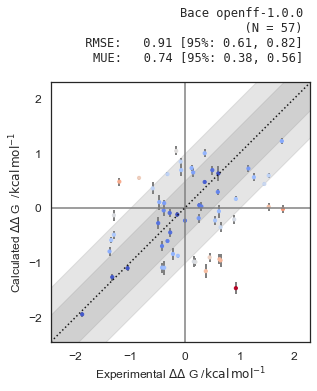

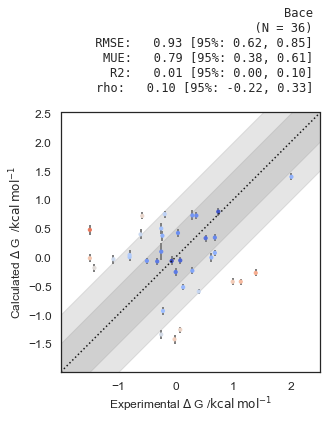

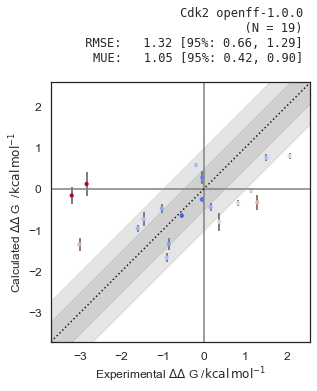

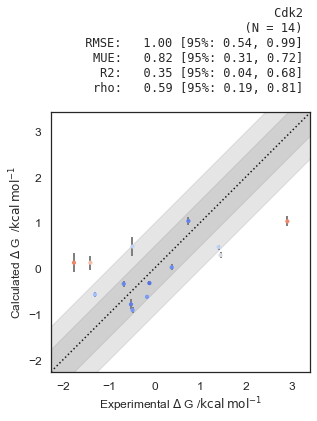

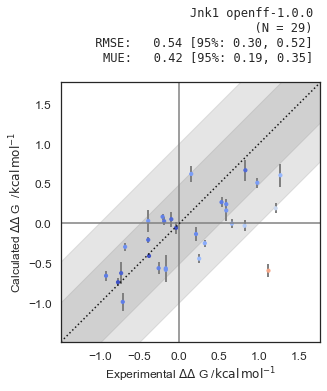

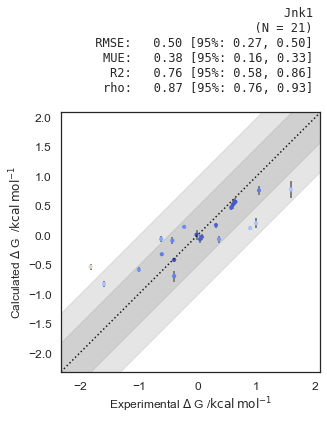

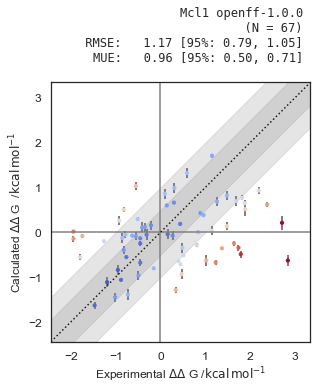

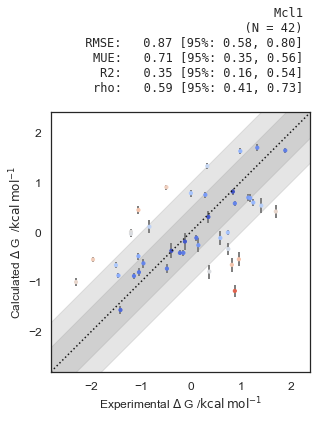

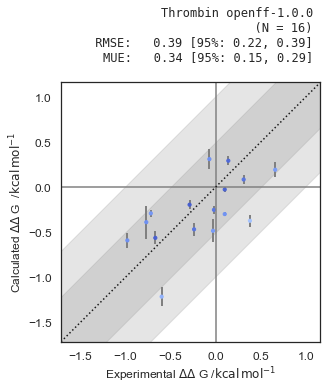

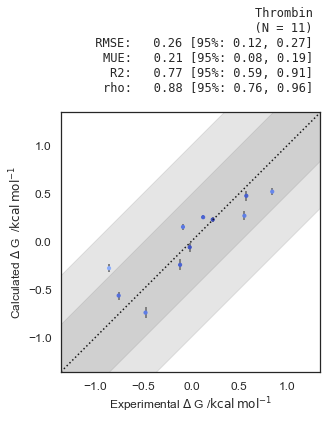

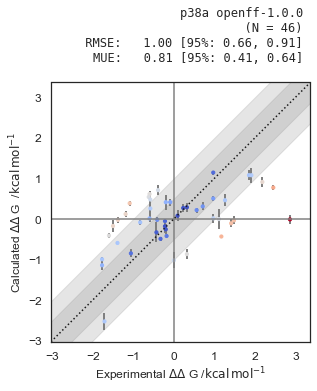

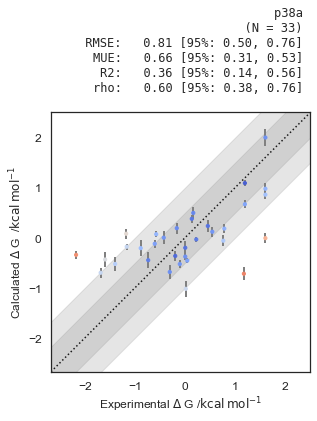

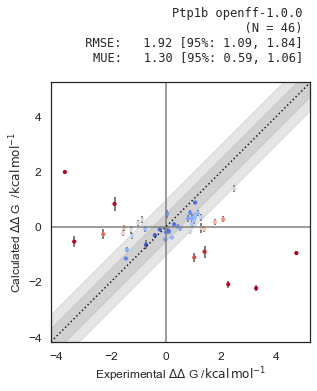

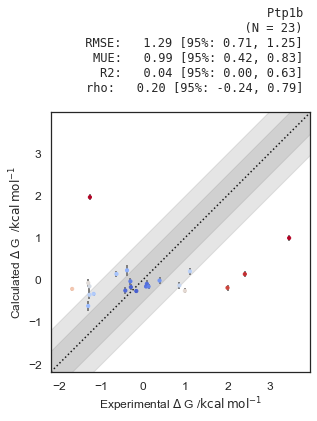

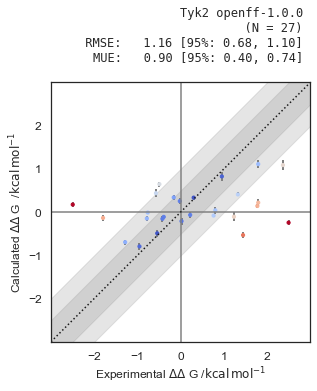

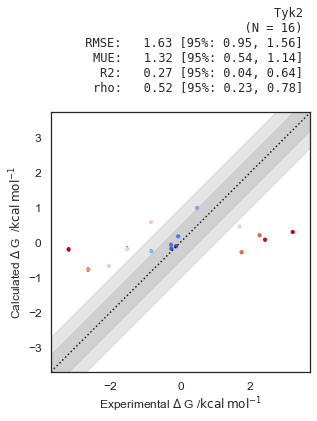

In [49]:
from freeenergyframework import wrangle, plotting, stats
for file in csv_files:
    print(file)
    network = wrangle.FEMap(file)
    plotting.plot_DDGs(network.results, title=f'{file.split("-")[0]} openff-1.0.0', filename=f'{file[0:-4]}DDGs.png')
    plotting.plot_DGs(network.graph, title=f'{file.split("-")[0]}', filename=f'{file[0:-4]}DGs.png')

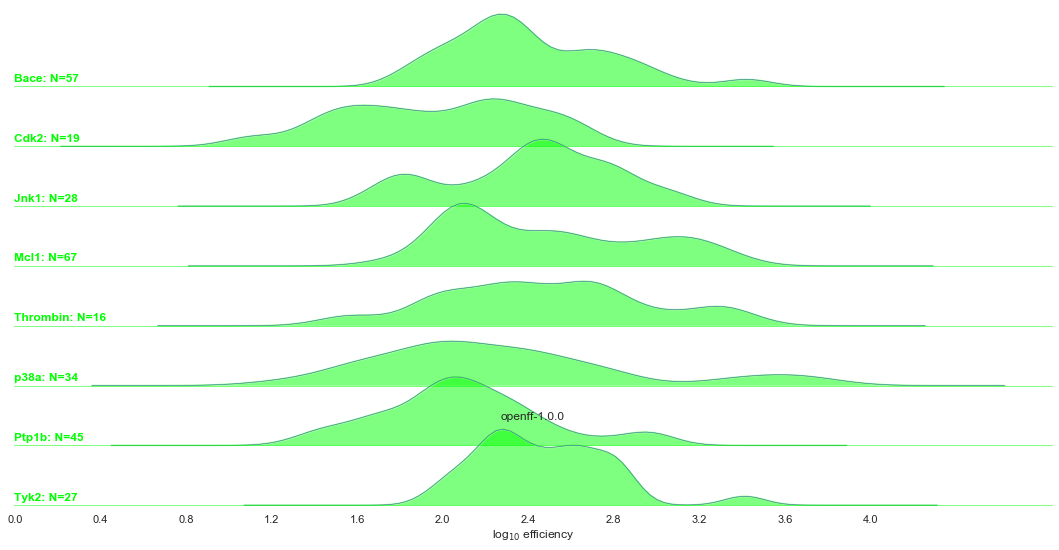

In [23]:
####
# Not sure if we should group FF's or targets here?? Maybe depends on what the results look like
####

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

for ff in forcefields:
    data = []
    for target in targets:
        for sim in getattr(target,'all_sims'+ff):
            try:
                var = ((np.asarray(sim.solddg))**2 + (np.asarray(sim.comddg))**2)**0.5
                eff = -np.log10(var)
                data.append([target.name,eff])
            except TypeError:
                print(f'error with {target.name}, {sim.directory}')
                continue    
    
    variance_df = pd.DataFrame(data, columns = ['g', r'log$_{10}$ efficiency']) 
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
#     pal = [list(target.color) for target in targets]
    pal = [forcefield_color[ff] for _ in targets]

    g = sns.FacetGrid(variance_df, row="g", hue="g", aspect=15, height=1., palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, r'log$_{10}$ efficiency', clip_on=False, shade=True, alpha=0.5, lw=1.5, bw=.3)
    g.map(sns.kdeplot, r'log$_{10}$ efficiency', clip_on=False, color="b", lw=0.6, bw=.3)
    g.map(plt.axhline, y=0, lw=1, alpha=0.5, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        target = globals()[label.capitalize()]
#         color = target.color
        ax = plt.gca()
        sims = getattr(target,'all_sims'+ff)
        ax.text(0, 0.1, f'{label}: N={len(sims)}', fontweight="bold", color=forcefield_color[ff],
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, r'log$_{10}$ efficiency')

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set(xticks=list(np.linspace(0.,4.0,11)))
    # g.set(xlabel='efficiency')
    g.despine(bottom=True, left=True)
    plt.title(ff)
    plt.show()

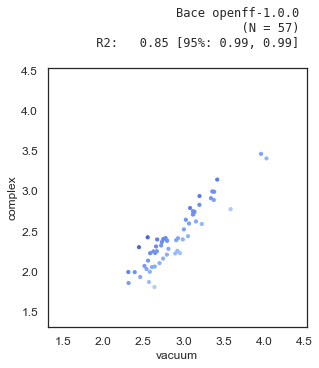

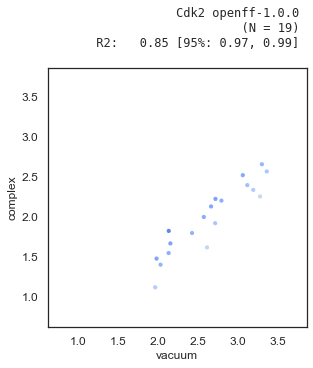

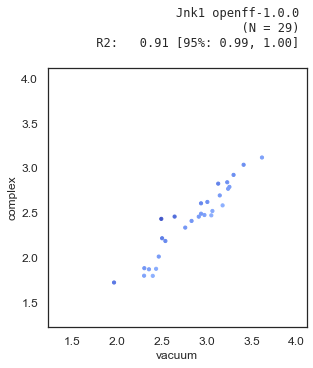

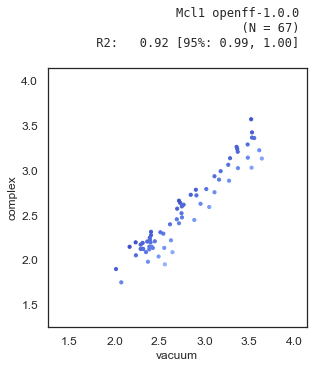

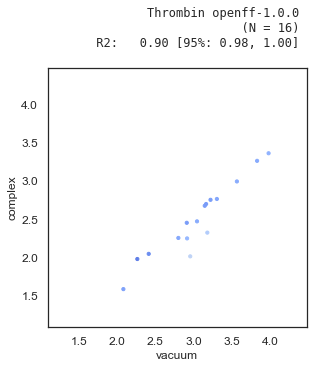

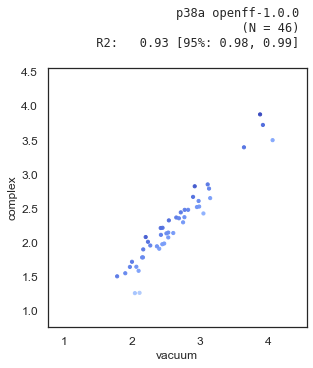

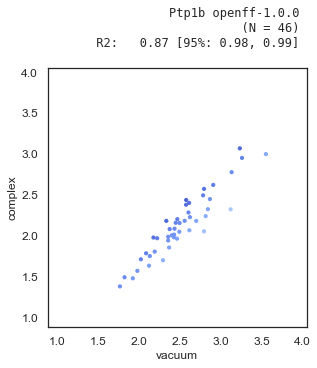

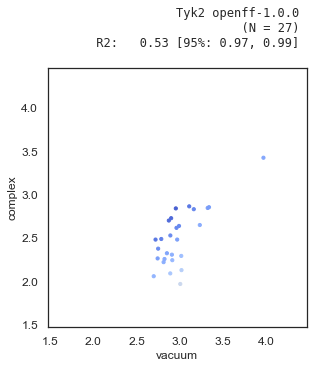

In [52]:
for ff in forcefields:
    data = []
    for target in targets:
        var_com = np.asarray([-np.log10(sim.comddg) for sim in getattr(target,'all_sims'+ff)])
        var_sol = np.asarray([-np.log10(sim.solddg) for sim in getattr(target,'all_sims'+ff)])
        var_vac = np.asarray([-np.log10(sim.vacddg) for sim in getattr(target,'all_sims'+ff)])
#         plotting._master_plot(var_vac, var_sol, statistics=['R2'],guidelines=False, origins=False, title=f'{target.name} {ff}',xlabel='vacuum', ylabel='solvent')
        plotting._master_plot(var_sol, var_com, statistics=['R2'],guidelines=False, origins=False, title=f'{target.name} {ff}',xlabel='vacuum', ylabel='complex')
#         plotting._master_plot(var_sol, var_com, statistics=['R2'],guidelines=False, origins=False, title=f'{target.name} {ff}',xlabel='solvent', ylabel='complex')


In [ ]:
# NEED AN UPDATED ENDSTATE PLOT

# for ff in forcefields:
#     n_y = 2
#     n_x = 1
#     size = 7
#     fig = plt.figure(figsize=[7,7])

#     shiftdg = []
#     shiftddg = []
#     bins = np.linspace(0,1,21)
#     for target in targets:
#         for sim in getattr(target,'all_sims'+ff):
#             shiftdg.append(np.abs(sim.bindingdg_es-sim.bindingdg))
#             shiftddg.append(sim.bindingddg_es-sim.bindingddg)

#     xlabels = [r'Change in BFE on addition of endstates / kcal mol$^{-1}$',
#                 r'Change in $variance$ of BFE with endstates / kcal mol$^{-1}$']      
#     for plot_index,method in enumerate([shiftdg, shiftddg],1):   
#         plt.title(ff)
#         plt.subplot(n_y, n_x, plot_index)
#         plt.hist(method,bins=bins,alpha=0.6)
#         plt.xlabel(xlabels[plot_index-1])
#     plt.subplots_adjust(hspace=0.3)
#     plt.show()

In [ ]:
# sns.set_style("white")

# for target in completed:
#     shift = {}
#     for ff in forcefields:
#         target_shift = []
#         for node in target.graph.nodes(data=True):
#             no_es = np.abs(node[1]['exp'] - node[1]['f_i'+ff])
#             es = np.abs(node[1]['exp'] - node[1]['f_i_es'+ff])
#             target_shift.append(es - no_es)
#         shift[ff] = target_shift
#     shift = pd.DataFrame.from_dict(shift)
#     plt.figure(figsize=(7,7))
#     plt.vlines(0., -0.5, 3.5,linestyles='dashed',color='gray',alpha=0.5)
#     print('If shift = 0 the end states do nothing. If positive, endstates moving it further from experimental')
#     sns.violinplot(data=shift,label=[str(ff) for ff in forcefields], # label isn't working...
#                    orient='h',palette=[forcefield_color[ff] for ff in forcefields])
#     plt.xlabel('Distance to experimental')
#     plt.title(target.name)
#     plt.xlim(-0.5,0.5)
#     plt.show()


In [ ]:
# plt.figure(figsize=(7,7))
# sns.set_style("white")

# MUEdf = pd.DataFrame(columns=['Target','MUE','Endstates'])
# colors=[]

# for target in completed:
#     for ff in forcefields:
#         for node in target.graph.nodes(data=True):
#             no_es = np.abs(node[1]['exp'] - node[1]['f_i'+ff])
#             es = np.abs(node[1]['exp'] - node[1]['f_i_es'+ff])
#             MUEdf = MUEdf.append({'Target':target.name,'MUE':no_es,'Endstates':False},ignore_index=True)
#             MUEdf = MUEdf.append({'Target':target.name,'MUE':es,'Endstates':True},ignore_index=True)
#         colors.append(target.color)
#     sns.violinplot(x='Target',y='MUE',data=MUEdf,hue='Endstates', split=True,
#                    bw=0.2,palette='muted',inner="stick",linewidth=1.)
#     plt.ylabel(r'MUE / kcal mol$^{-1}$')
#     plt.xlabel('Target')
#     plt.show()        

In [ ]:
# sns.set(style="white")


# plt.figure(figsize=(7,7))
# for target in targets:
#     for i,ff in enumerate(forcefields):
#         xs = []
#         ys = []
#         for sim in getattr(target,'all_sims'+ff):
#             xs.append(-np.log10(sim.vacddg))
#             ys.append(-np.log10(sim.solddg))
#         stats = bootstrap_statistic(np.asarray(xs),np.asarray(ys),statistic='R2')
#         plt.scatter(xs,ys,color=forcefield_color[ff],label=f"R2  :  {stats['mle']:5.2f} [95%: {stats['low']:5.2f}, {stats['high']:5.2f}] kcal/mol {ff}")
# plt.xlabel('log10 Efficiency, vacuum')
# plt.ylabel('log10 Efficiency, solvent')
# plt.legend()
# plt.show()

# plt.figure(figsize=(7,7))
# for target in targets:
#     for i,ff in enumerate(forcefields):
#         xs = []
#         ys = []
#         for sim in getattr(target,'all_sims'+ff):
#             xs.append(-np.log10(sim.vacddg))
#             ys.append(-np.log10(sim.comddg))
#         stats = bootstrap_statistic(np.asarray(xs),np.asarray(ys),statistic='R2')
#         plt.scatter(xs,ys,color=forcefield_color[ff],label=f"R2  :  {stats['mle']:5.2f} [95%: {stats['low']:5.2f}, {stats['high']:5.2f}] kcal/mol {ff}")
# plt.xlabel('log10 Efficiency, vacuum')
# plt.ylabel('log10 Efficiency, complex')
# plt.legend()
# plt.show()
                    
# plt.figure(figsize=(7,7))
# for target in targets:
#     for i,ff in enumerate(forcefields):
#         xs = []
#         ys = []
#         for sim in getattr(target,'all_sims'+ff):
#             xs.append(-np.log10(sim.solddg))
#             ys.append(-np.log10(sim.comddg))
#         stats = bootstrap_statistic(np.asarray(xs),np.asarray(ys),statistic='R2')
#         plt.scatter(xs,ys,color=forcefield_color[ff],label=f"R2  :  {stats['mle']:5.2f} [95%: {stats['low']:5.2f}, {stats['high']:5.2f}] kcal/mol {ff}")
# plt.xlabel('log10 Efficiency, solvent')
# plt.ylabel('log10 Efficiency, complex')
# plt.legend()
# plt.show()                    

In [ ]:
sns.set_style("white")

for target in targets:
    temp = nx.DiGraph()
    for ff in forcefields:
        for sim in getattr(target,'all_sims'+ff):
            f, (fe_fig, err_fig) = plt.subplots(2,1, sharex=True,figsize=(7,7))
            plt.subplots_adjust(hspace=0.0)
            fe_fig.set_title(f'{target.name} {sim.directory}')

            # now plotting with endstates
            bfe_history = np.asarray(sim.soldg_history) - np.asarray(sim.comdg_history)
            error_history = ((np.asarray(sim.solddg_history))**2 + (np.asarray(sim.comddg_history))**2)**0.5 # THIS IS IN KJ
            xaxis = np.linspace(0.,5.,len(bfe_history))
            fe_fig.plot(xaxis,bfe_history)
            fe_fig.fill_between(xaxis,bfe_history - error_history, bfe_history + error_history, alpha = 0.2)
            err_fig.plot(xaxis,error_history, color='grey')
            err_fig.plot(xaxis,sim.solddg_history,linestyle='dotted',label='solvent', color='grey')
            err_fig.plot(xaxis,sim.comddg_history,linestyle='dashed',label='complex', color='grey')    


            err_fig.set_ylabel(r'$\delta \Delta \Delta G_{bind}$',fontsize=20)
            fe_fig.set_ylabel(r'$\Delta \Delta G_{bind}$',fontsize=20)
            plt.xlabel('Simulation time / ns',fontsize=20)
            mean = np.mean(bfe_history)
            fe_fig.set_ylim(mean-2.,mean+2.)
            err_fig.set_ylim(0.,3.)

        plt.legend()
        plt.show()
                

In [ ]:
nanoseconds = range(1,6,5) # check once per nanosecond
# change this to DDG's

targets = [Bace]
for target in targets:
    temp = nx.DiGraph()
    f, figures = plt.subplots(6,1, sharex=True,figsize=(10,15))
    rmse_fig, mue_fig, r2_fig, rho_fig,rmse_fig_ddg, mue_fig_ddg  = figures
    for ff in forcefields:
        plt.subplots_adjust(hspace=0.0)
        statistics = np.zeros((6,len(nanoseconds)))
        statistics_high =np.zeros((6,len(nanoseconds)))
        statistics_low = np.zeros((6,len(nanoseconds)))
        for n,nano in enumerate(nanoseconds):
            temp = generate_graph_results(temp,target,ff,interval=nano)
            abs_dict = {}
            err_dict = {}

            for node in temp.nodes(data=True):
                abs_dict[target.name.lower()+'_'+node[1]['name']+ff] = node[1]['f_i'+ff]
                err_dict[target.name.lower()+'_'+node[1]['name']+ff] = node[1]['df_i'+ff]
            for i, row in df.iterrows(): 
#                 for ff in forcefields:
                if row['ID']+ff in abs_dict:
                    df.at[i,ff] = abs_dict[row['ID']+ff]
                    df.at[i,ff+'err'] = err_dict[row['ID']+ff]
            
            # Plot dG and ddG between all ligand pairs
            for each, rows in df.groupby("Target"): 
                if each in [t.name.lower() for t in completed]:
                    if target.name == each.capitalize():
                        for j,statistic in enumerate(('RMSE', 'MUE','R2','rho')):
                            stats = bootstrap_statistic(rows['EXP'].values, rows[ff].values, statistic=statistic,plot_type='ddG')
                            statistics[j,n] = stats['mean']
                            statistics_high[j,n] = stats['high']
                            statistics_low[j,n] = stats['low']
                        for j,statistic in enumerate(('RMSE', 'MUE'),4):
                            stats = bootstrap_statistic(rows['EXP'].values, rows[ff].values, statistic=statistic,plot_type='dG')
                            statistics[j,n] = stats['mean']
                            statistics_high[j,n] = stats['high']
                            statistics_low[j,n] = stats['low']
                            
        rmse_fig.set_title(target.name)
        for fig,(r,h,l) in zip(figures,zip(statistics,statistics_high,statistics_low)):
            fig.plot(range(1,6),r,color=forcefield_color[ff])
            fig.fill_between(range(1,6),h,l,alpha=0.01,color=forcefield_color[ff])
    rmse_fig.set_ylabel(r'RMSE $(\Delta G)$ / kcal mol$^{-1}$')    
    mue_fig.set_ylabel(r'MUE $(\Delta G)$ / kcal mol$^{-1}$')  
    r2_fig.set_ylabel(r'R$^2 (\Delta G)$') 
    r2_fig.set_ylim(0.,1.)
    rho_fig.set_ylabel(r'$\rho (\Delta G)$')
    rho_fig.set_ylim(0.,1.)
    
    rmse_fig_ddg.set_ylabel(r'RMSE $(\Delta \Delta G)$ / kcal mol$^{-1}$')
    mue_fig_ddg.set_ylabel(r'MUE $(\Delta \Delta G)$ / kcal mol$^{-1}$')  
    
    rho_fig.set_xlabel('Simulation time / ns')
    plt.show()